# PCA (Principal component analysis )

PCA is  a technique to reduce dimensions of a dataset while maximising variations so that patterns can be revealved and explored.

Let's start with with a simple dataset, for example, human height and weight.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm
import re

We create some random data

In [0]:
np.random.seed(0)
height = truncnorm(-1, 1, loc=1.65, scale=0.25).rvs(20) # random height from 1.40 to 1.90 m
weight = np.random.uniform(30, 20, len(height)) * height ** 2 + np.random.normal(0, 5, len(height))
waist = np.random.uniform(0.35, 0.85, len(height)) * height

Check their distribution.


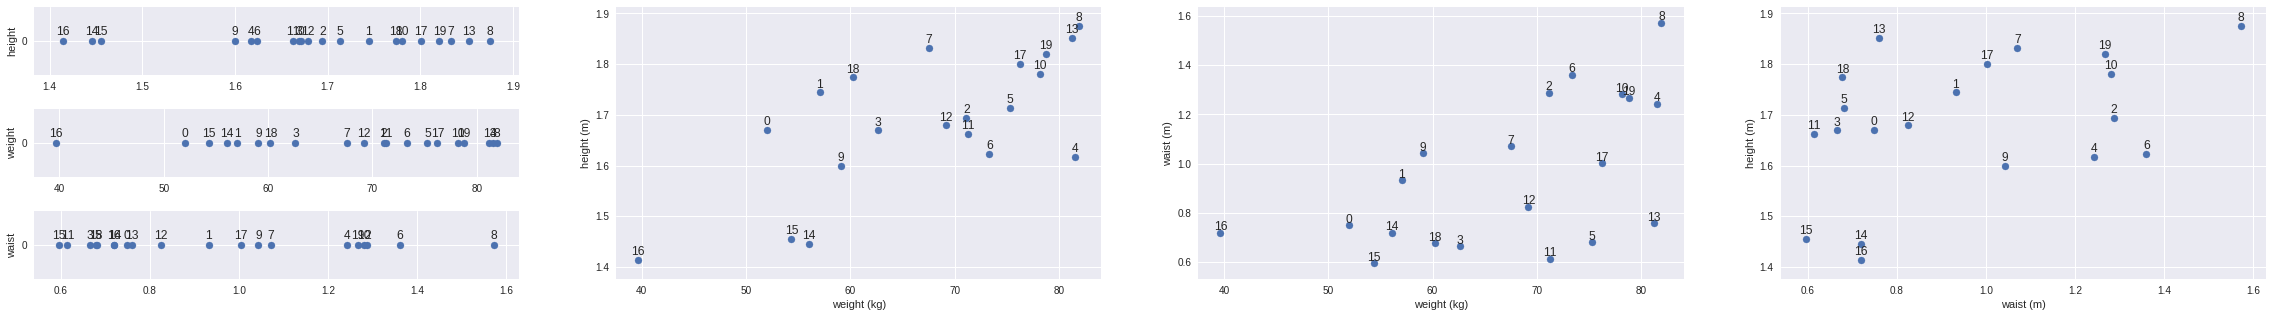

In [3]:
plt.figure(figsize=(40, 5))
plt.subplots_adjust(hspace=0.5)
ax1 = plt.subplot2grid((3, 4), (0, 0))
ax2 = plt.subplot2grid((3, 4), (1, 0))
ax3 = plt.subplot2grid((3, 4), (2, 0))
ax4 = plt.subplot2grid((3, 4), (0, 1), rowspan=3)
ax5 = plt.subplot2grid((3, 4), (0, 2), rowspan=3)
ax6 = plt.subplot2grid((3, 4), (0, 3), rowspan=3)

ax1.scatter(height, np.zeros(len(height)))
ax1.set_ylabel('height')
ax1.yaxis.set_ticks([0])
for i, _ in enumerate(height): ax1.annotate(i, (height[i], 0.01), horizontalalignment = 'center')
ax2.scatter(weight, np.zeros(len(height)))
ax2.set_ylabel('weight')
ax2.yaxis.set_ticks([0])
for i, _ in enumerate(height): ax2.annotate(i, (weight[i], 0.01), horizontalalignment = 'center')
ax3.scatter(waist, np.zeros(len(height)))
ax3.set_ylabel('waist')
ax3.yaxis.set_ticks([0])
for i, _ in enumerate(height): ax3.annotate(i, (waist[i], 0.01), horizontalalignment = 'center')

ax4.scatter(weight, height)
ax4.set_xlabel('weight (kg)')
ax4.set_ylabel('height (m)');
for i, _ in enumerate(height): ax4.annotate(i, (weight[i], height[i] + 0.01), horizontalalignment = 'center')
    
ax5.scatter(weight, waist)
ax5.set_xlabel('weight (kg)')
ax5.set_ylabel('waist (m)');
for i, _ in enumerate(height): ax5.annotate(i, (weight[i], waist[i] + 0.01), horizontalalignment = 'center')
    
ax6.scatter(waist, height)
ax6.set_xlabel('waist (m)')
ax6.set_ylabel('height (m)');
for i, _ in enumerate(height): ax6.annotate(i, (waist[i], height[i] + 0.01), horizontalalignment = 'center')

So the question is: how do we describe them or seperate them out as much as possible
- We can use height. Person 19, 7, 13, 8 are among the tallest, person 16 the shortest. What about those in the middle whose measurment are clustered together and it's harder to tell them apart.
- We can use weight. Person 16 is the lightest and so on. We again have people with similar measurement.
- The same goes for waist measurement.
- We can combine weight & height. In the scatter plot, we see that this combination can seperate out most people. Further, we can have a combination of weight vs waist, or waist vs height, or a combination of height, weight, waist.

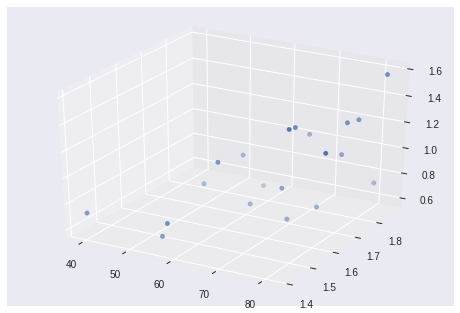

In [4]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(weight, height, waist);

With only 20 people, using 2 characteristics, we can tell most of them apart.
For example:
- height 1.88, weight 81.9 can be mapped to person 8 
- height 1.41, weight 39.7 can be mapped to person 16

Etc. But imagine if we have 100+ people, their height and weight will have higher chances of overlapping, then it's harder to tell them apart. We can utilise the waist feature. But, eventually, the combination of height, weight, waist will not be sufficient to seperate the more people we have.

We can think of the forth feature: for example, the length of an arm. Then the fifth feature and so on, from hundreds of human anthropometric features. But it will be super hard for us to visualise the fourth dimension in a graph. This is when **PCA** comes in.

PCA seeks to maximise covariance between features and then reduce these features (dimensions) to managable dimensions so we can reason about them.

Let's check out some codes

In [5]:
# 1, variance
print('''Variance:
Height: {:.6f}
Weight: {:.6f}
Waist: {:.6f}
'''.format(np.cov(height), np.cov(weight), np.cov(waist))) # using np.cov instead of np.var because np.cov use df - 1

# and their covariance
print(np.cov([height, weight, waist]))

Variance:
Height: 0.017859
Weight: 137.394311
Waist: 0.087213

[[1.78586953e-02 1.07938164e+00 1.66807237e-02]
 [1.07938164e+00 1.37394311e+02 1.98616919e+00]
 [1.66807237e-02 1.98616919e+00 8.72131558e-02]]


We can see that the covariance are:
- Between height & weight: 1.079
- Between height & waist: 0.017
- Between weight & waist: 1.986

But since they are in different units (m vs kg), it is advised to normalise them to mean of 0 and std of 1

In [0]:
height_scaled = (height - height.mean()) / height.std(ddof = 1)
weight_scaled = (weight - weight.mean()) / weight.std(ddof = 1)
waist_scaled = (waist - waist.mean()) / waist.std(ddof = 1)

Now they are all scaled to mean of 0 and std of 1

In [7]:
np.cov([height_scaled, weight_scaled, waist_scaled]) # np.corrcoef([height, weight, waist]) # this gives the same result

array([[1.        , 0.68907388, 0.42266766],
       [0.68907388, 1.        , 0.573774  ],
       [0.42266766, 0.573774  , 1.        ]])

So the correlation 
- Between height & weight: 0.689
- Between height & waist: 0.423
- Between weight & waist: 0.574

We can see that:
- Height ranges from -2.0 to 1.4
- Weight ranges from -2.4 to 1.2

Can we project these points onto a line so their variances are maximised?



/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


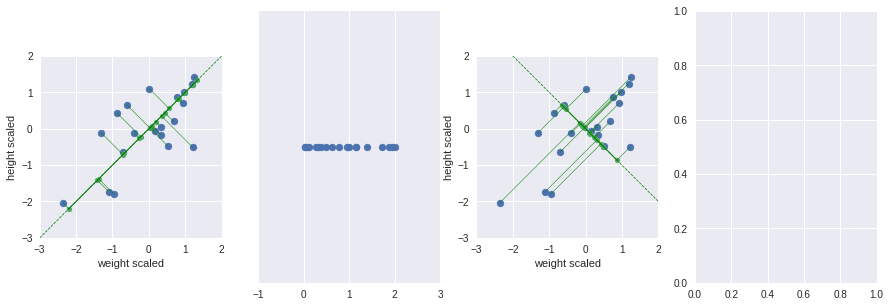

In [8]:
_, axs = plt.subplots(1, 4, figsize=(15, 5))

# first plot
axs[0].scatter(weight_scaled, height_scaled)
axs[0].set_xlabel('weight scaled')
axs[0].set_ylabel('height scaled')
axs[0].axis('square')
axs[0].axis([-3, 2, -3, 2])

# the green line
axs[0].plot([-3, 2], [-3, 2], ls='--', lw=0.75, color='green');

# points on the green line
w_online = (weight_scaled + height_scaled) / 2
h_online = (weight_scaled + height_scaled) / 2
axs[0].scatter(w_online, h_online, s=25, lw=0.25)
axs[0].plot([w_online.min(), w_online.max()], [h_online.min(), h_online.max()], ls='-', lw=1, color='green')

# distance from blue dots to small green dots
for i in range(0, len(height)):
    axs[0].plot([weight_scaled[i], w_online[i]], [height_scaled[i], h_online[i]], ls='-', lw=0.5, color='green')

    
axs[1].scatter(np.sqrt(w_online ** 2 + h_online **2), np.zeros(len(height)))
axs[1].axis([-1, 3, 0, 0])
axs[1].yaxis.set_ticks([])

# second plot
axs[2].scatter(weight_scaled, height_scaled)
axs[2].set_xlabel('weight scaled')
axs[2].set_ylabel('height scaled')
axs[2].axis('square')
axs[2].axis([-3, 2, -3, 2])

# the green line
axs[2].plot([-2, 2], [2, -2], ls='--', lw=0.75, color='green');

# points on the green line
w_online = (weight_scaled - height_scaled) / 2
h_online = (-weight_scaled + height_scaled) / 2
axs[2].scatter(w_online, h_online, s=25, lw=0.25)
axs[2].plot([w_online.min(), w_online.max()], [h_online.max(), h_online.min()], ls='-', lw=1, color='green')

# distance from blue dots to small green dots
for i in range(0, len(height)):
    axs[2].plot([weight_scaled[i], w_online[i]], [height_scaled[i], h_online[i]], ls='-', lw=0.5, color='green')


On the left, we have the green line where the blue dots can project on.  This line has the maximum variance
On the right, when we rotate the green line, we can see the green solid line gets shorter, so does the variance.

In [0]:
# data = pd.read_csv('data_nutrition.csv')
# data_sub = data[data.Shrt_Desc.str.contains(r'(?i)apple|banana|cherr|melon|peanut|broco|potato|coconut|orange|tomato|walnut|almond|avocado|cucumber|kiwi|carrot', regex=True)]
# data_sub